# Evaluators

In [1]:
from overrides import overrides
from typing import List, Optional
from archai.discrete_search.api import ArchaiModel

We will use SegmentationDag search space for this example

In [2]:
from archai.discrete_search.search_spaces.cv import SegmentationDagSearchSpace

In [3]:
ss = SegmentationDagSearchSpace(nb_classes=1, img_size=(64, 64), max_layers=5, seed=11)

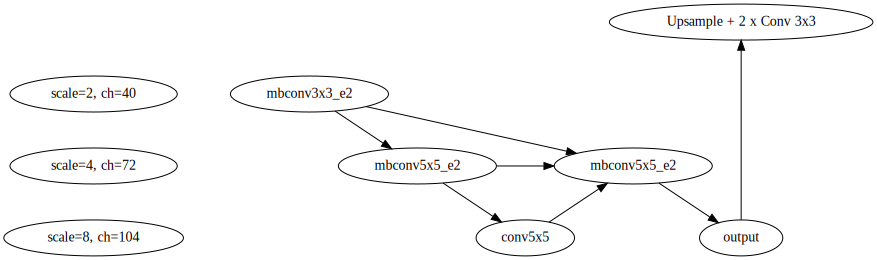

In [4]:
m = ss.random_sample()
m.arch.view()

`SegmentationDagSearchSpace` is a subclass of `EvolutionarySearchSpace`, so `mutate` and `crossover` methods are already implemented

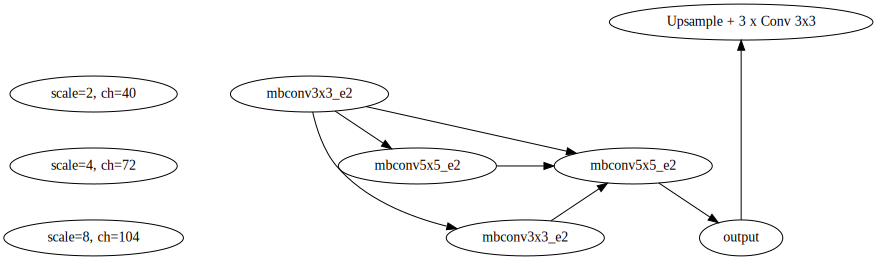

In [5]:
ss.mutate(m).arch.view()

## Evaluating models

`Evaluators` are the main tool used to evaluate architectures in given criteria (task performance, speed, size, etc.). Archai supports two types of `Evaluators`:

* ModelEvaluator ([archai.discrete_search.api.evaluator.ModelEvaluator](https://microsoft.github.io/archai/reference/api/archai.discrete_search.api.html#module-archai.discrete_search.api.evaluator.ModelEvaluator))
    * Evaluates a model: `ModelEvaluator.evaluate(model, budget)`

* AsyncModelEvaluator ([archai.discrete_search.api.evaluator.AsyncModelEvaluator](https://microsoft.github.io/archai/reference/api/archai.discrete_search.api.html#module-archai.discrete_search.api.evaluator.AsyncModelEvaluator)):
    * Sends an evaluation job: `AsyncModelEvaluator.send(model, budget)`
    * Fetches all evaluation jobs from the queue: `AsyncObjective.fetch_all()` 
  
A synchronous evaluator (`ModelEvaluator`) is computed by the search algorithm in a sequential fashion, while an asynchronous evaluator (`AsyncModelEvaluator`) sends evaluation jobs to a queue and fetches the results later, and thus can be used to evaluate models remotely or in a distributed fashion.

The `ArchaiModel` object passed to the evaluator objects can be used to access the architecture, if necessary. Some objectives will actively use the a dataset (e.g task accuracy), while others (e.g FLOPs, latency, memory) may not.

The `budget` argument, if provided, is a multiplier value used by search algorithms like `SucessiveHalving` to specify how much compute should be spent on the evaluation.

Read more about Evaluators [here](https://microsoft.github.io/archai/reference/api/archai.discrete_search.api.html#module-archai.discrete_search.api.evaluator). You can find a list of built-in evaluators in `archai.discrete_search.evaluators`.

### Example: Using a built-in evaluator (`AvgOnnxLatency`)

Let's use a built-in evaluator to measure ONNX latency of PyTorch models

In [6]:
from archai.discrete_search.evaluators import AvgOnnxLatency

In [7]:
onnx_latency_obj = AvgOnnxLatency(input_shape=(1, 3, 64, 64))
onnx_latency_obj.evaluate(model=ss.random_sample(), budget=None)

0.000640645157545805

### Custom Evaluator Example

Let's create a simple custom `ModelEvaluator` that counts the number of modules in a model

In [8]:
from archai.api.dataset_provider import DatasetProvider
from archai.discrete_search.api import ModelEvaluator

In [9]:
class NumberOfModules(ModelEvaluator):
    ''' Class that measures the size of a model by the number of torch modules '''
    
    @overrides
    def evaluate(self, model: ArchaiModel,
                 budget: Optional[float] = None):
        return len(list(model.arch.modules()))

In [10]:
m = ss.random_sample()

In [11]:
my_objective = NumberOfModules()
my_objective.evaluate(m)

67

### Useful Evaluators

* [RayParallelEvaluator](https://microsoft.github.io/archai/reference/api/archai.discrete_search.objectives.html#module-archai.discrete_search.evaluators.ray) - Wraps an existing `ModelEvaluator` into a new `AsyncModelEvaluator` that runs evaluation jobs using multiple Ray workers.

* [EvaluationFunction](https://microsoft.github.io/archai/reference/api/archai.discrete_search.objectives.html#module-archai.discrete_search.evaluators.functional) - Wraps a function that takes (model, budget) arguments and creates a `ModelEvaluator`

#### Example: Parallelizing NumberOfModules

Let's use `RayParallelEvaluator` to make our custom evaluator `NumberOfModules` run more efficiently.

In [12]:
from archai.discrete_search.evaluators import RayParallelEvaluator

In [13]:
my_objective_parallel = RayParallelEvaluator(
    NumberOfModules(), 
    timeout=10, # Timeout in seconds
    num_cpus=1.0 # Each evaluation job will use a CPU core
)

`my_objective_parallel` is now an `AsyncModelEvaluator` object. We can send evaluation jobs calling `AsyncModelEvaluator.send(model, budget)`:

In [14]:
model_list = [ss.random_sample() for _ in range(10)]

for model in model_list:
    print(f'Dispatching job for {model.archid}')
    my_objective_parallel.send(model, budget=None)

Dispatching job for 4aba6fbdb292e44d634daefa425ab1406684daed_64_64


2023-03-08 05:29:52,185	INFO worker.py:1518 -- Started a local Ray instance.


Dispatching job for e0521c00e4b6dfa7f624d2d7560d9c220591864b_64_64
Dispatching job for c60496d4923eaa0062de511eaab3b9cb4ec46a3e_64_64
Dispatching job for d31e4ef0912834bc51336aaf55fd879606fbf4ca_64_64
Dispatching job for 915ff7e0aca6e48bbae0def46d64b7300887fb80_64_64
Dispatching job for 90da2af4f0a0aa0f24cafa1cd59032623ada1c23_64_64
Dispatching job for fe6c11c85bbcbdaf6b716d9259f5415b7327192d_64_64
Dispatching job for 65e92bee3ecc899c5c346be82961c331d9f18933_64_64
Dispatching job for bdf6f69e2a8e08473e9e799ec2d7e627dd915d43_64_64
Dispatching job for 9b0f792a6e6c37c4e40abde72b4fbd2cdca9ebae_64_64


We can fetch and clear all jobs from the job queue by calling `AsyncModelEvaluator.fetch_all()`

In [15]:
my_objective_parallel.fetch_all()

[53, 29, 60, 31, 87, 49, 30, 83, 33, 61]

After that, job queue should be empty

In [16]:
assert my_objective_parallel.fetch_all() == []

#### Example: Wrapping custom training code into an Evaluator

Let's consider the problem of measuring the task performance on a specific dataset with custom training code. 

In [17]:
from archai.datasets.cv.mnist_dataset_provider import MnistDatasetProvider
from archai.discrete_search.evaluators import EvaluationFunction

Datasets in Archai are defined using dataset providers. We will use the built-in `MnistProvider` dataset provider for the MNIST dataset.

In [18]:
dataset_provider = MnistDatasetProvider()

We can now wrap custom training code easily using the `EvaluationFunction` wrapper:

```python
def custom_training_val_performance(model, budget=None):
    tr_data = dataset_provider.get_train_dataset()
    val_data = dataset_provider.get_val_dataset()

    tr_dl = torch.utils.data.DataLoader(tr_data, shuffle=True, batch_size=16)
    val_dl = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=16)

    optimizer = torch.optim.Adam(model.arch.parameters(), lr=1e-3)
    ...

    for batch in tr_dl:
        ...

    for batch in val_dl:
        ...

    return validation_metric
```

```python

# Wraps custom training function into a ModelEvaluator
custom_evaluator = EvaluationFunction(custom_traininb_val_performance)

# Evaluates an architecture from the search space
custom_evaluator.evaluate(ss.random_sample(), budget=None)
```

See the next notebook for a complete example using a custom training objectives